# Решение тестового задания на позицию Junior Data Scientist (NLP)
## Трифонов Р.С.

[Вакансия](https://chita.hh.ru/vacancy/68620322?from=negotiations_item&hhtmFrom=negotiations_item)

##  Анализ задачи

### Бизнес задача
Необходимо контролировать менеджеров на соответствие требованиям скрипта продаж - т.е. необходимо проверять, чтобы выполнялось следующее условие: «В каждом диалоге обязательно необходимо поздороваться и попрощаться с клиентом»

### ML задача
- Необходимо решить задачу бинарной классификации: метка 1 - менеджер выполнил требование, метка 0 - менеджер не выполнил требование.
- Извлекать реплики с приветствием – где менеджер поздоровался.
- Извлекать реплики, где менеджер представил себя.
- Извлекать имя менеджера.
- Извлекать название компании.
- Извлекать реплики, где менеджер попрощался.
- Проверять требование к менеджеру: «В каждом диалоге обязательно необходимо поздороваться и попрощаться с клиентом»

### Аналитическая задача
- Оперативный контроль менеджеров на соответствие требованиям скрипта продаж, через дашборд


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('dark')

import spacy

from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
import pandas as pd
from dash import callback, Input, Output, State
from dash import dash_table

In [2]:
data_path = 'test_data.csv'
data = pd.read_csv(data_path)
data.tail()

,dlg_id,line_n,role,text
475,5,138,manager,По поводу виджетов и с ними уже обсудите конкр...
476,5,139,manager,Все я вам высылаю счет и с вами на связи если ...
477,5,140,client,Спасибо спасибо
478,5,141,client,Да да тогда созвонимся ага спасибо вам давайте
479,5,142,manager,Ну до свидания хорошего вечера


## EXPLORATORY DATA ANALYSIS

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dlg_id  480 non-null    int64 
 1   line_n  480 non-null    int64 
 2   role    480 non-null    object
 3   text    480 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.1+ KB


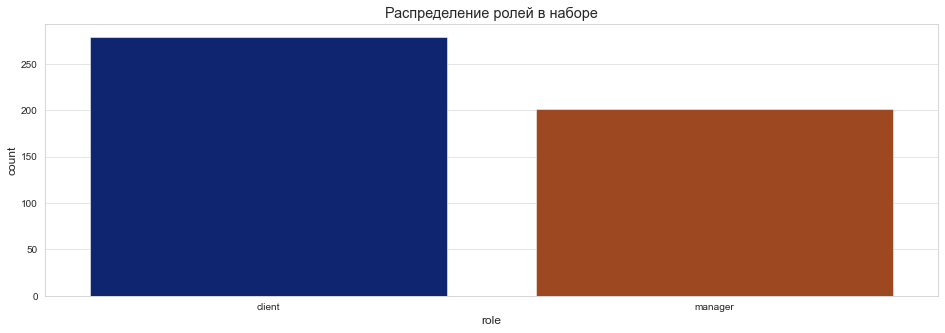

In [4]:
plt.figure(figsize=(16,5))
sns.countplot(x='role', data= data, order = data['role'].value_counts().index)
plt.title('Распределение ролей в наборе')
plt.show()

In [5]:
# Определим длинну ответов менеджеров
data['len_response'] = data.loc[data['role'] == 'manager']['text'].str.len()

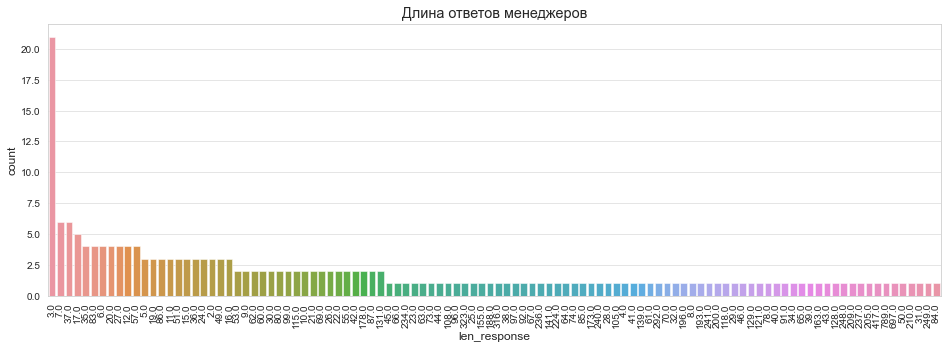

In [6]:
plt.figure(figsize=(16,5))
sns.countplot(x='len_response', data= data, order = data['len_response'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Длина ответов менеджеров')
plt.show()

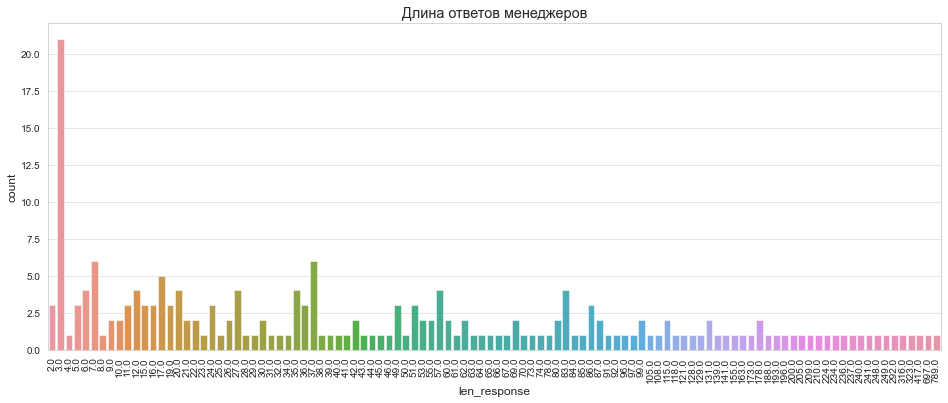

In [7]:
plt.figure(figsize=(16,6))
sns.countplot(x='len_response', data= data)
plt.xticks(rotation=90)
plt.title('Длина ответов менеджеров')
plt.show()

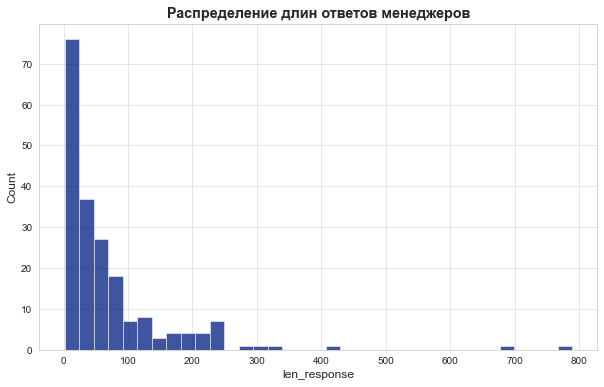

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(data=data['len_response'], bins=35)
plt.title('Распределение длин ответов менеджеров',fontweight="bold")
plt.show()

##  DATA PREPARATION

- Во время разговора с клиентом ожидается, что менеджер приветствует клиента в начале диалога и прощается в конце т.е. длинна реплик, где это происходит не должна превышать 3.
- Самопредставление включает в себя леммы: 'меня', 'звать'
- Приветствие включает леммы: 'здравствовать', 'привет', 'добрый', 'день', 'утро', 'вечер'
- Прощание включает леммы: 'до', 'всего', 'весь', 'свидание', 'хороший', 'добрый'
- Название фирмы включает леммы: 'компан', 'фирм'

In [9]:
def skipping_middle_replica(x):
    agg_val = x.tolist()
    return agg_val[:3] + agg_val[-3:]

def entity_allocation_rules(name_model):
    nlp = spacy.load(name_model)
    ruler = nlp.add_pipe('entity_ruler', config={"overwrite_ents": True})
    patterns = [
        {"label": "name", "pattern": [
            {'LEMMA': 'меня', "OP": "+"},
            {'LEMMA': 'звать', "OP": "?"},
            {'ENT_TYPE': 'PER', "OP": "+"}]},
        {'label': 'organisation', 'pattern': [
            {"LOWER": {"REGEX": r"(компан|фирм)"}, "OP": "+"},
            {"LOWER": {"REGEX": r"\w+"}}]},
        {'label': 'greetings', 'pattern': [
            {"LEMMA": {"IN": ['здравствовать', 'привет', 'добрый']}, "OP": "+"},
            {"LOWER": {"REGEX": r"(день|утро|вечер)", "OP": "?"}}]},
        {'label': 'goodbyes', 'pattern': [
            {"LEMMA": {"IN": ['до', 'всего', 'весь'], "OP": "+"}},
            {"LEMMA": {"IN": ['свидание', 'хороший', 'добрый'], "OP": "+"}}]}
    ]
    ruler.add_patterns(patterns)
    return nlp

def parse_entity(data, model_name):
    data['index_text'] = [str(k) + '_' + v for k, v in zip(range(len(data.text.values)), data.text.values)]

    new_col = ['name', 'organisation', 'greetings', 'goodbyes', 'fulfilling_requirement']

    list_text = data[data.role == 'manager'].groupby(['dlg_id'])['index_text'].apply(skipping_middle_replica)

    model = entity_allocation_rules(model_name)

    data[new_col] = [False] * len(new_col)

    tmp = []
    for i in range(len(list_text)):
        six_task = set()
        for doc in model.pipe(list_text[i]):
            idx, text = doc.text.split('_')
            idx = int(idx)
            doc = model(text)
            for ent in doc.ents:
                tmp.append(idx)
                if ent.label_ == 'name':
                    data.loc[idx, new_col[0]] = ent.text.split()[-1]
                if ent.label_ == 'organisation':
                    data.loc[idx, new_col[1]] = ent.text
                if ent.label_ == 'greetings':
                    data.loc[idx, new_col[2]] = ent.text
                    six_task.add(1)
                if ent.label_ == 'goodbyes':
                    data.loc[idx, new_col[3]] = ent.text
                    six_task.add(2)
        if sum(six_task) == 3:
            data.loc[idx, new_col[4]] = True

    return data.drop('index_text', axis = 1), tmp

##  MODELING

In [10]:
df, tmp = parse_entity(data, 'ru_core_news_lg')

In [11]:
df = df.loc[sorted(set(tmp))]
df

,dlg_id,line_n,role,text,len_response,name,organisation,greetings,goodbyes,fulfilling_requirement
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес з...,128.0,ангелина,компания диджитал,False,False,False
108,0,108,manager,Всего хорошего до свидания,26.0,False,False,False,до свидания,False
111,1,2,manager,Меня зовут ангелина компания диджитал бизнес з...,131.0,ангелина,компания диджитал,False,False,False
162,1,53,manager,Угу да вижу я эту почту хорошо тогда исправлю ...,86.0,False,False,False,всего хорошего,False
163,1,54,manager,До свидания,11.0,False,False,False,До свидания,False
167,2,3,manager,Меня зовут ангелина компания диджитал бизнес з...,129.0,ангелина,компания диджитал,False,False,False
250,3,1,manager,Алло дмитрий добрый день,24.0,False,False,добрый день,False,False
251,3,2,manager,Добрый меня максим зовут компания китобизнес у...,60.0,максим,компания китобизнес,False,False,False
253,3,4,manager,Да дмитрий вот мне моя коллега анастасия подск...,248.0,False,False,False,False,False
300,3,51,manager,Угу все хорошо да понедельника тогда всего доб...,50.0,False,False,False,всего доброго,True


## Dashboard

In [12]:
df['name'].replace({False: 'Не указанно'}, inplace=True)

In [13]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# Create server variable with Flask server object for use with gunicorn
server = app.server

app.layout = html.Div([
    html.Div([
        
        html.H4('Выполнение скрипта продаж менеджерами',
                        style={'text-align': 'center',
                               'margin-top': '10px',
                               'margin-left': '10px',
                               'margin-right': '10px'}),


        
        html.Div([
        dash_table.DataTable(
        data= data.groupby(['name','fulfilling_requirement']).\
                agg(requirement = ('fulfilling_requirement', 'sum')).\
                reset_index().\
                to_dict('records'),
            
        columns=[
            {'name': 'Менеджер', 'id': 'name', 'type': 'text'},
            {'name': 'Выполнение скрипта', 'id': 'requirement', 'type': 'numeric'},

        ]
    )
        
        
        ])
        
    ])
    
])

app.run_server(mode="inline")

Дашборд и аналитику в целом можно усложнить и развернуть, как отдельное приложение. Если у нас есть постоянное поступление данных, то можно написать ETL конвейер на Airflow для с использованием данного подхода и мониторить менеджеров на постоянной основе.  